In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [3]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(0.4),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
batch_size = 4

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
trainset, valset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.batch_nor1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch_nor2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_nor1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_nor2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
from torchsummary import summary
test_model = CNN()
summary(test_model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
       BatchNorm2d-2          [-1, 6, 220, 220]              12
         MaxPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
       BatchNorm2d-5         [-1, 16, 106, 106]              32
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Linear-7                  [-1, 120]       5,393,400
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 5,407,330
Trainable params: 5,407,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 8.07
Params size (MB): 20.63
Estimated Total Size (MB): 29.27
-------------------------------------

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Epoch = 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


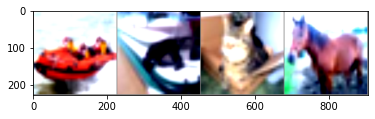

 ship  ship   cat horse


In [11]:
import matplotlib.pyplot as plt
import torchvision

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [12]:
for epoch in range(Epoch):
    running_loss = 0.0
    running_corrects = 0.0

    val_loss = 0.0
    val_corrects = 0.0
    total = 0

    model.train()
    for idx, data in enumerate(train_loader):
      # get the input; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # print statistics
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)
      if idx % 2000 == 1999:
        print('[Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, running_loss / 2000))
        running_loss = 0.0
        running_corrects = 0.0
    
    # -------- Validation --------
    model.eval()
    with torch.no_grad():
      for idx, data in enumerate((val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predict = model(inputs)
        loss = criterion(predict, labels)

        _, vals = torch.max(predict, 1)
        val_loss += loss.item()
        val_corrects += (vals == labels).sum().item()
        total += labels.size(0)
    print('Validation [Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, val_loss / total))
    print('Validation Acc: %.3f %%'%(val_corrects / total * 100))

    # -------- Schedule Learning Rate --------
    scheduler.step()
    print("Learning Rate: ", scheduler.get_last_lr()[0])

print('Finish Training')

[Epoch: 1,  1999] loss: 2.001
[Epoch: 1,  3999] loss: 1.827
[Epoch: 1,  5999] loss: 1.746
[Epoch: 1,  7999] loss: 1.709
[Epoch: 1,  9999] loss: 1.656
Validation [Epoch: 1,  2499] loss: 0.394
Validation Acc: 41.840 %
Learning Rate:  0.00027
[Epoch: 2,  1999] loss: 1.606
[Epoch: 2,  3999] loss: 1.577
[Epoch: 2,  5999] loss: 1.567
[Epoch: 2,  7999] loss: 1.523
[Epoch: 2,  9999] loss: 1.508
Validation [Epoch: 2,  2499] loss: 0.364
Validation Acc: 46.410 %
Learning Rate:  0.000243
[Epoch: 3,  1999] loss: 1.453
[Epoch: 3,  3999] loss: 1.441
[Epoch: 3,  5999] loss: 1.426
[Epoch: 3,  7999] loss: 1.404
[Epoch: 3,  9999] loss: 1.406
Validation [Epoch: 3,  2499] loss: 0.338
Validation Acc: 51.080 %
Learning Rate:  0.0002187
[Epoch: 4,  1999] loss: 1.355
[Epoch: 4,  3999] loss: 1.353
[Epoch: 4,  5999] loss: 1.335
[Epoch: 4,  7999] loss: 1.331
[Epoch: 4,  9999] loss: 1.309
Validation [Epoch: 4,  2499] loss: 0.327
Validation Acc: 52.740 %
Learning Rate:  0.00019683
[Epoch: 5,  1999] loss: 1.295
[Epo

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# for confusion matrix
y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            y_pred.append(prediction.cpu().numpy())
            y_true.append(label.cpu().numpy())
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 71.0 %
Accuracy for class car   is: 67.8 %
Accuracy for class bird  is: 45.3 %
Accuracy for class cat   is: 51.3 %
Accuracy for class deer  is: 55.4 %
Accuracy for class dog   is: 46.4 %
Accuracy for class frog  is: 70.8 %
Accuracy for class horse is: 61.4 %
Accuracy for class ship  is: 70.8 %
Accuracy for class truck is: 72.2 %


# Reference  https://stackoverflow.com/questions/58589349/pytorch-confusion-matrix-plot

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.ylim(-0.5, len(classes) - 0.5)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.71  0.018 0.065 0.037 0.015 0.007 0.017 0.014 0.076 0.041]
 [0.043 0.678 0.022 0.021 0.005 0.006 0.025 0.003 0.035 0.162]
 [0.089 0.005 0.453 0.13  0.122 0.059 0.081 0.027 0.025 0.009]
 [0.037 0.011 0.085 0.513 0.073 0.144 0.064 0.029 0.017 0.027]
 [0.029 0.004 0.148 0.078 0.554 0.028 0.075 0.069 0.006 0.009]
 [0.016 0.004 0.08  0.271 0.063 0.464 0.025 0.058 0.01  0.009]
 [0.013 0.004 0.065 0.106 0.064 0.017 0.708 0.012 0.008 0.003]
 [0.034 0.005 0.038 0.099 0.096 0.071 0.009 0.614 0.008 0.026]
 [0.122 0.043 0.022 0.027 0.01  0.01  0.01  0.006 0.708 0.042]
 [0.048 0.074 0.01  0.033 0.012 0.016 0.017 0.036 0.032 0.722]]
[[710  18  65  37  15   7  17  14  76  41]
 [ 43 678  22  21   5   6  25   3  35 162]
 [ 89   5 453 130 122  59  81  27  25   9]
 [ 37  11  85 513  73 144  64  29  17  27]
 [ 29   4 148  78 554  28  75  69   6   9]
 [ 16   4  80 271  63 464  25  58  10   9]
 [ 13   4  65 106  64  17 708  12   8   3]
 [ 34   5  38  99  96  71   9 614   8  2

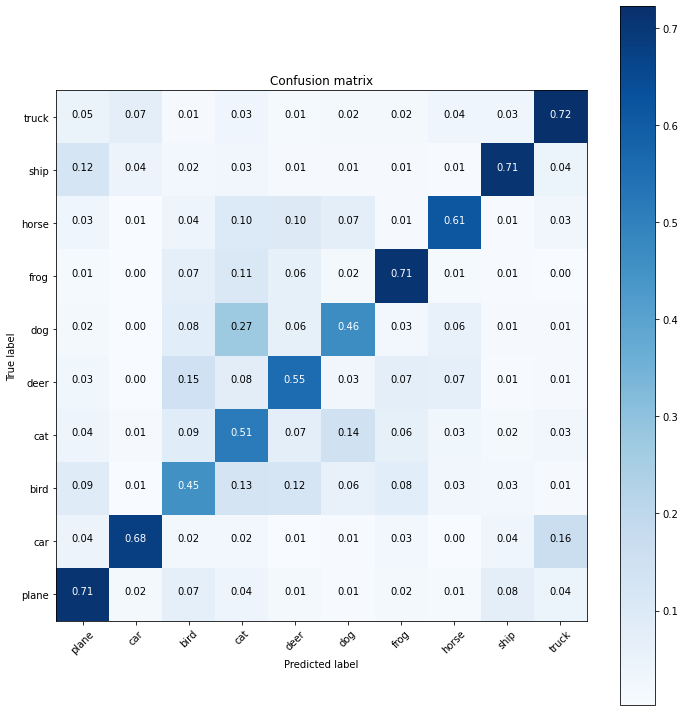

In [15]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cf_matrix, classes, normalize=True)
print(cf_matrix)

# Pre-trained Model

In [16]:
from efficientnet_pytorch import EfficientNet

pre_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10, advprop=False).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

Loaded pretrained weights for efficientnet-b0


In [ ]:
for epoch in range(Epoch):
    running_loss = 0.0
    running_corrects = 0.0

    val_loss = 0.0
    val_corrects = 0.0
    total = 0

    pre_model.train()
    for idx, data in enumerate(train_loader):
      # get the input; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = pre_model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # print statistics
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)
      if idx % 2000 == 1999:
        print('[Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, running_loss / 2000))
        running_loss = 0.0
        running_corrects = 0.0
    
    # -------- Validation --------
    pre_model.eval()
    with torch.no_grad():
      for idx, data in enumerate((val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predict = pre_model(inputs)
        loss = criterion(predict, labels)

        _, vals = torch.max(predict, 1)
        val_loss += loss.item()
        val_corrects += (vals == labels).sum().item()
        total += labels.size(0)
    print('Validation [Epoch: %d, %5d] loss: %.3f'%(epoch + 1, idx, val_loss / total))
    print('Validation Acc: %.3f %%'%(val_corrects / total * 100))

print('Finish Training')

In [ ]:
# prepare to count predictions for each class
pre_correct_pred = {classname: 0 for classname in classes}
pre_total_pred = {classname: 0 for classname in classes}

pre_y_pred = []
pre_y_true = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = pre_model(images)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            pre_y_pred.append(prediction.cpu().numpy())
            pre_y_true.append(label.cpu().numpy())
            if label == prediction:
                pre_correct_pred[classes[label]] += 1
            pre_total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in pre_correct_pred.items():
    accuracy = 100 * float(correct_count) / pre_total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(pre_y_true, pre_y_pred)
plot_confusion_matrix(cf_matrix, classes)